# Final project guidelines

**Note:** Use these guidelines if and only if you are pursuing a **final project of your own design**. For those taking the final exam instead of the project, see the (separate) final exam notebook.

### The task

Your task is to: identify an interesting problem connected to the humanities or humanistic social sciences that's addressable with the help of computational methods, formulate a hypothesis about it, devise an experiment or experiments to test your hypothesis, present the results of your investigations, and discuss your findings.

These tasks essentially replicate the process of writing an academic paper. You can think of your project as a paper in miniature.

You are free to present each of these tasks as you see fit. You should use narrative text (that is, your own writing in a markdown cell), citations of others' work, numerical results, tables of data, and static and/or interactive visualizations as appropriate. Total length is flexible and depends on the number of people involved in the work, as well as the specific balance you strike between the ambition of your question and the sophistication of your methods. But be aware that numbers never, ever speak for themselves. Quantitative results presented without substantial discussion will not earn high marks. 

Your project should reflect, at minimum, ten **or more** hours of work by each participant, though you will be graded on the quality of your work, not the amount of time it took you to produce it. Most high-quality projects represent twenty or more hours of work by each member.

#### Pick an important and interesting problem!

No amount of technical sophistication will overcome a fundamentally uninteresting problem at the core of your work. You have seen many pieces of successful computational humanities research over the course of the semester. You might use these as a guide to the kinds of problems that interest scholars in a range of humanities disciplines. You may also want to spend some time in the library, reading recent books and articles in the professional literature. **Problem selection and motivation are integral parts of the project.** Do not neglect them.

### Format

You should submit your project as a PDF document created using the included $\LaTeX{}$ template. Consult the template for information on formatting and what is expected in each section. You can use your favorite text editor or something like [Overleaf](https://www.overleaf.com/) to edit this document. You will also submit this Jupyter notebook, along with all data necessary to reproduce your analysis. If your dataset is too large to share easily, let us know in advance so that we can find a workaround. 

All code used in the project should be present in the notebook (except for widely-available libraries that you import), but **be sure that we can read and understand your report in full without rerunning the code**. 

Because you are submitting essentially a mini-paper in the PDF writeup, I don't have any particular formatting expections for written material in this notebook. However, you should include **all code used when completing the final project, with comments added for clarity**. It should be straightforward to map code from the notebook to sections/figures/results in your paper, and vice versa.

### Grading

This project takes the place of the take-home final exam for the course. It is worth 35% of your overall grade. You will be graded on the quality and ambition of each aspect of the project. No single component is more important than the others.

### Practical details

* The project is due at **4:30 PM EST on Wednesday, December 17** via upload to CMS of a single zip file containing your fully executed Jupyter notebook report, a PDF copy of the notebook, and all associated data. **You may not use slip days for the final project or exam**. 
* You may work alone or in a group of up to three total members.
    * If you work in a group, be sure to list the names of the group members.
    * For groups, create your group on CMS and submit one notebook for the entire group. **Each group should also submit a statement of responsibility** that describes in general terms who performed which parts of the project.
* You may post questions on Ed, but should do so privately (visible to course staff only).

---

## Your info
* NetID(s): rr772, aa2289, kx63
* Name(s): Razika Rahman, Afran Ahmed, Kyleena Xin
---

In [90]:
# imports go here
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, f1_score, r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.feature_selection import SelectKBest
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


from   sklearn.decomposition import LatentDirichletAllocation


In [63]:
data = pd.read_csv("data/tedtalk_sample.csv")

data.head()

data_y = data['views']
data_for_vec = data.drop(columns=['views'])

In [ ]:
#Vectorizer

vectorizer = TfidfVectorizer(
    input = "content",
    encoding = "utf-8",
    stop_words = "english",
    strip_accents= "unicode",
    min_df= 10,
    max_df = 0.4,
    norm = 'l2',
    use_idf=True
)

#fit vectorizer onto corpus
data_vectorized = vectorizer.fit_transform(data_for_vec['transcript'])
print(f"Shape of Feature Matrix: {data_vectorized.shape}")

#store feature names + values
feature_name = vectorizer.get_feature_names_out()
val = data_vectorized.mean(axis = 0).A1

top_features = pd.DataFrame({
    "feature": feature_name,
    "value": val
}).sort_values("value", ascending = False)

top_features.head(30)

Shape of Feature Matrix: (1000, 7008)


,feature,value
6935,women,0.022334
1663,data,0.016306
6305,technology,0.015973
4193,music,0.015665
3596,kids,0.014302
5536,school,0.014285
5905,space,0.013952
1138,children,0.013839
6840,water,0.013707
3321,information,0.013679


In [95]:
#utilized from lecture 09
def print_top_words(model, feature_names, n_top_words, hide_stops=False):
    if hide_stops:
        from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

    for topic_idx, topic in enumerate(model.components_):
        message = f"Topic {topic_idx: >2}: "
        top_words_idx = topic.argsort()
        if not hide_stops:
            top_words = [feature_names[i]
                         for i in top_words_idx[:-n_top_words - 1:-1]]
        else:
            top_words = []
            i = 1
            while len(top_words) < n_top_words:
                if feature_names[top_words_idx[-i]] not in ENGLISH_STOP_WORDS:
                    top_words.append(feature_names[top_words_idx[-i]])
                i += 1
        message += " ".join(top_words)    
        print(message)
    print()

In [111]:
#LDA
lda = LatentDirichletAllocation(
    n_components= 7,
    n_jobs=-1,
    max_iter= 50,
    learning_method= 'batch',
    doc_topic_prior= 0.1,
    topic_word_prior= 0.01,
    evaluate_every=0,
    random_state=42
)

lda.fit(data_vectorized)

print_top_words(lda, vectorizer.get_feature_names_out(), n_top_words=10, hide_stops=False)

Topic  0: gun prison regret prisoners saturn torture uv grief prisons georgia
Topic  1: music patent jeans ends starts distorted zoom exists exhausting exhibit
Topic  2: technology water information health design energy country money food power
Topic  3: women data kids school space children brain music earth light
Topic  4: ghana baltimore hug thinker malnutrition expectancy existence executives exercise exhausted
Topic  5: universe star stars planets mars mathematics capture galaxy dinosaurs electric
Topic  6: neurons microbes ai muscle muscles antibiotics flies bone fruit interactive



## Non-Textual Findings ##

First, using a supervised logistic regression model, using non-text features such as duration, recorded date, occupations, and other categorical columns, we want to predict whether a TED talk is popular or not. We define popular as a video that has higher than the median value of views. We also did some feature engineering, which included preserving the the top 25 jobs, and relabeling other jobs as "Other" due to the large number and variety. The most viewed TED talk had an astounding 56,932,551 views. And the least viewed TED Talk in the dataset had 119,999 views. After the cleaning, we had to convert all of these categorical features into binary indicators so our model could properly process them.

Secondly, using an unsupervised model like K means clustering, what kind of patterns are there in the data.


In [30]:
df = pd.read_csv("data/tedtalk_sample.csv")

#creating a popular/high views column to define what high views means in the dataset
df["high_views"] = (df["views"] > df["views"].median()).astype(int)

# polishing up the features to be easier to work with!
df["recorded_year"] = pd.to_datetime(df["recorded_date"]).dt.year
df["log_comments"] = np.log1p(df["comments"])
df["log_duration"] = np.log1p(df["duration"])

top_jobs = df["occupations"].value_counts().nlargest(25).index
df["occupation_clean"] = df["occupations"].where(
    df["occupations"].isin(top_jobs), "Other"
)

In [69]:
#we dropped the first column here to avoid multi colinearity
X_categorical = pd.get_dummies(
    df[["occupation_clean"]],
    drop_first=True
)

X_num = df[["log_comments", "log_duration", "recorded_year"]]

X = pd.concat([X_num, X_categorical], axis=1)
y = df["high_views"]

#scaling the features so they all contribute and are weighted fairly
scaler = StandardScaler()
X[X_num.columns] = scaler.fit_transform(X[X_num.columns])

#logistic regression process as used in lecture 5
logit_clf = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)

f1 = cross_val_score(
    logit_clf,
    X,
    y,
    scoring = "f1",
    cv = 5
)

print("Mean logit, crossvalidated, f1:", f1.mean())

logit_clf.fit(X, y)
y_logit = logit_clf.predict(X)
coef_df = (
    pd.DataFrame({
        "feature": X.columns,
        "coef": logit_clf.coef_[0]
    })
    .sort_values(by="coef", ascending=False)
)
coef_df.head(15)


Mean logit, crossvalidated, f1: 0.710672763091532


,feature,coef
0,log_comments,1.345930
2,recorded_year,1.247797
8,occupation_clean_{0: ['author']},1.182201
9,occupation_clean_{0: ['behavioral economist']},0.681135
20,occupation_clean_{0: ['neuroscientist']},0.519503
21,occupation_clean_{0: ['philosopher']},0.461141
10,occupation_clean_{0: ['biologist']},0.460152
4,occupation_clean_{0: ['architect']},0.380554
13,occupation_clean_{0: ['economist']},0.367574
25,occupation_clean_{0: ['surgeon']},0.155709


This tells us that across 5 different training and testing splits, the logistic regression model that we created was able to come to an average F1 score of around 0.71 when trying to predict whether a talk was popular or not popular.

C:\Users\Kyleena Xin\AppData\Local\Temp\ipykernel_56132\3687067734.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = top_feats["coef"], y = top_feats["feature"], palette = 'Paired')


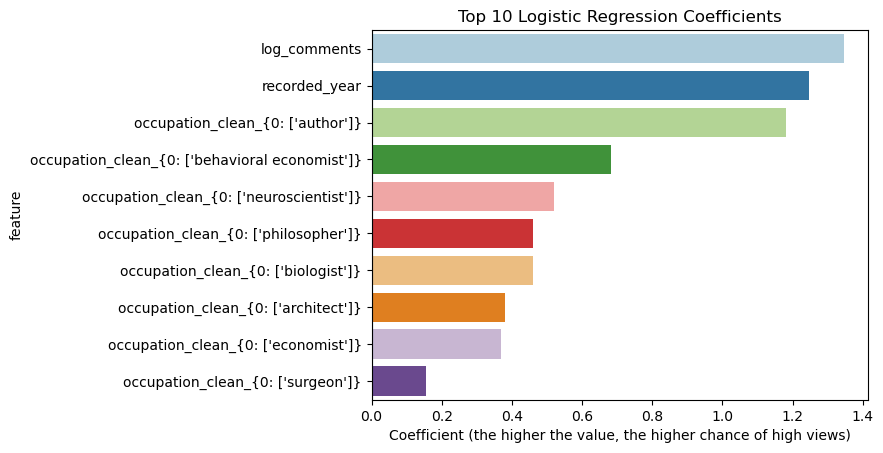

In [ ]:
top_feats = coef_df.head(10)

sns.barplot(x = top_feats["coef"], y = top_feats["feature"], palette = 'Paired')
plt.axvline(0)
plt.title("Top 10 Logistic Regression Coefficients")
plt.xlabel("Coefficient (the higher the value, the higher chance of high views)")
plt.show()

This bar plot shows the top 10 features that had the highest logistic regression coefficients. Each coefficient represents how much a given feature is pushing the model toward predicting "high views" versus "low views," while holding all of the other features constant (lecture 5). As we can see here, the features that were engagement-related such as the comments was the strongest predictive signal, and the second highest logistic coefficient came from recorded year, followed by all of the occupation data. Talks by authors and behavioral economists were the most likely to be popular out of all of the occupations. There are coefficients here greater than 1 because logistic regression operates in log-odds space, and do not correspond directly to probabilities.

In [78]:
X_comments = df[["log_comments"]].copy()

scaler = StandardScaler()
X_comments["log_comments"] = scaler.fit_transform(X_comments)

logit_comments = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)

f1_comments = cross_val_score(
    logit_comments,
    X_comments,
    y,
    scoring="f1",
    cv=5
)

print("log_comments mean F1:", f1_comments.mean())


log_comments mean F1: 0.5897645530978995


In [81]:
X_duration = df[["log_duration"]].copy()

scaler = StandardScaler()
X_duration["log_duration"] = scaler.fit_transform(X_duration)

logit_duration = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)

f1_duration = cross_val_score(
    logit_duration,
    X_duration,
    y,
    scoring="f1",
    cv=5
)

print("log duration mean F1:", f1_duration.mean())

log duration mean F1: 0.5776251599581153


In [83]:
X_year = df[["recorded_year"]].copy()

scaler = StandardScaler()
X_year["recorded_year"] = scaler.fit_transform(X_year)

logit_year = LogisticRegression(
    max_iter = 1000,
    class_weight = "balanced",
    random_state = 42
)

f1_year = cross_val_score(
    logit_year,
    X_year,
    y,
    scoring = "f1",
    cv = 5
)

print("log recorded year mean F1:", f1_year.mean())

log recorded year mean F1: 0.5880649425103603


In [84]:
single_feature_results = pd.DataFrame({
    "Feature": ["log_comments", "log_duration", "recorded_year"],
    "Mean F1 (CV)": [
        f1_comments.mean(),
        f1_duration.mean(),
        f1_year.mean()
    ]
})

single_feature_results

,Feature,Mean F1 (CV)
0,log_comments,0.589765
1,log_duration,0.577625
2,recorded_year,0.588065


In [85]:
X_occupation = pd.get_dummies(df[["occupation_clean"]], drop_first=True)

clf = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)

f1_occ = cross_val_score(
    clf,
    X_occupation,
    y,
    scoring="f1",
    cv=5
)

print("Occupation-only F1:", f1_occ.mean())


Occupation-only F1: 0.43806067983005204


From these results, we can see that the comment count independently provides a strong predictive signal. And the duration and recorded year are also close as well. When we look at occupation only, it is a bit weaker than comments, duration, and recorded year. Overall, these independent coefficients differed from the combined mean coefficient by quite a lot. This suggests that combining the features drastically improves performance, and implies that popularity is driven by multiple combined factors.

## K-Means Clustering ##
Now we are using an unsupervised method, K-Means clustering, to see if these non-text features naturally reveal patterns that can determine if the speech is populare or not? Once again for this method, we decided to use the same non-text features as before. And we decided to look at numeric only clustering, leaving out occupation for now so it would be easier to interpret.

c:\Users\Kyleena Xin\miniconda3\envs\3350\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\Kyleena Xin\miniconda3\envs\3350\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


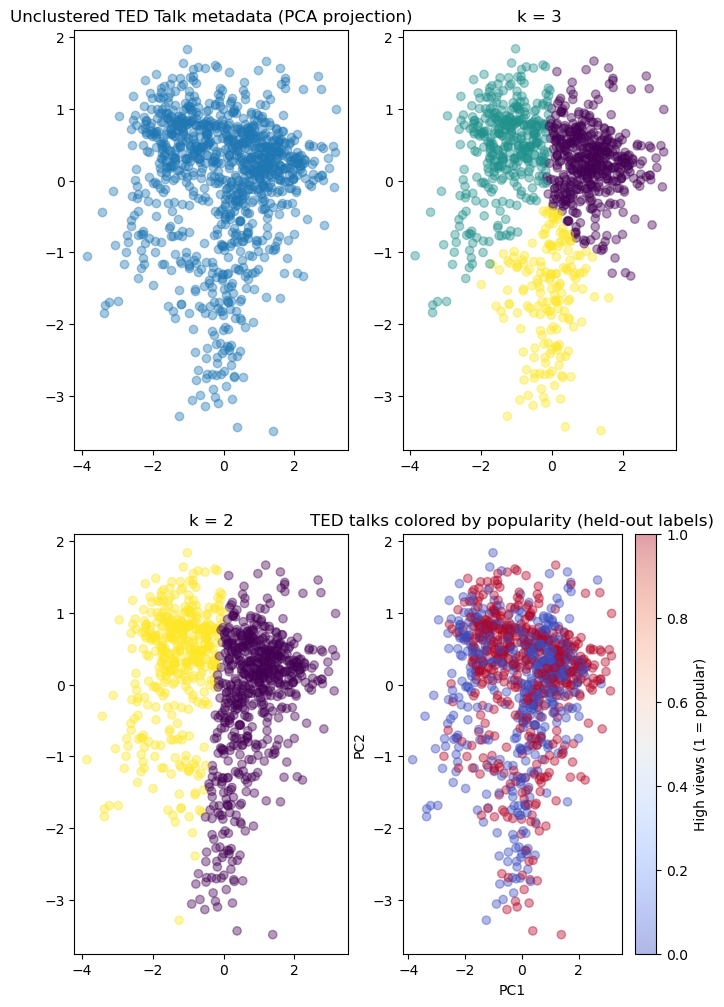

In [105]:
features = [
    "log_comments",
    "log_duration",
    "recorded_year"
]

X = df[features]
X_scaled = StandardScaler().fit_transform(X)

X_2d = PCA(n_components=2, random_state=42).fit_transform(X_scaled)

plt.figure(figsize=(12, 12))

# Unclustered data
plt.subplot(231)
plt.scatter(X_2d[:, 0], X_2d[:, 1], alpha=0.4)
plt.title("Unclustered TED Talk metadata (PCA projection)")

# 3 clusters!
y_pred = KMeans(
    n_clusters=3,
    random_state=42,
    n_init=10
).fit_predict(X_scaled)

plt.subplot(232)
plt.scatter(X_2d[:, 0], X_2d[:, 1], c = y_pred, alpha = 0.4)
plt.title("k = 3")


# 2 Clusters!
y_pred = KMeans(
    n_clusters=2,
    random_state=42,
    n_init=10
).fit_predict(X_scaled)

plt.subplot(234)
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_pred, alpha=0.4)
plt.title("k = 2")

plt.subplot(235)
plt.scatter(
    X_2d[:, 0],
    X_2d[:, 1],
    c=df["high_views"],
    cmap="coolwarm",
    alpha=0.4
)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("TED talks colored by popularity (held-out labels)")
plt.colorbar(label="High views (1 = popular)")
plt.show()


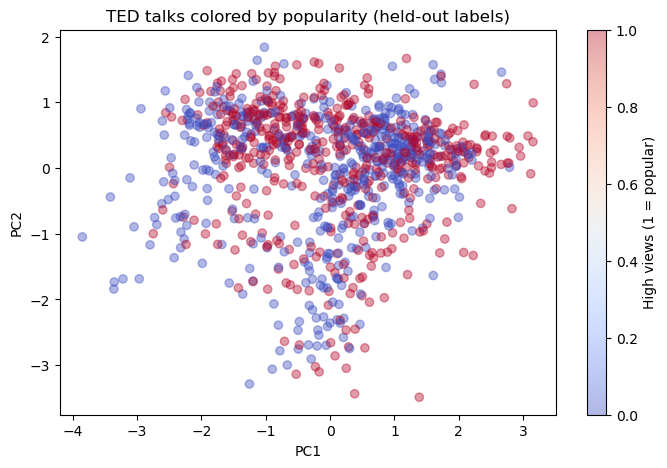

In [100]:
plt.figure(figsize=(8,5))

plt.scatter(
    X_2d[:, 0],
    X_2d[:, 1],
    c=df["high_views"],
    cmap="coolwarm",
    alpha=0.4
)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("TED talks colored by popularity (held-out labels)")
plt.colorbar(label="High views (1 = popular)")
plt.show()

In [99]:
df.groupby("cluster")[["log_comments", "log_duration", "recorded_year"]].describe()

log_comments                                                    \
               count      mean       std       min       25%       50%   
cluster                                                                  
0              457.0  5.133157  0.834091  2.564949  4.564348  5.093750   
1              370.0  3.336972  0.821822  0.693147  2.708050  3.401197   
2              173.0  4.825581  0.702591  2.833213  4.406719  4.875197   

                            log_duration            ...                      \
              75%       max        count      mean  ...       75%       max   
cluster                                             ...                       
0        5.645447  8.138857        457.0  6.868478  ...  7.013016  7.706613   
1        3.891820  5.455321        370.0  6.532872  ...  6.742586  7.195187   
2        5.283204  6.760415        173.0  5.885389  ...  6.154858  6.411818   

        recorded_year                                                         \
                count         mean       std     min     25%     50%     75%   
cluster                                                                        
0               457.0  2010.291028  3.335841  2002.0  2008.0  2011.0  2013.0   
1               370.0  2017.370270  1.476347  2012.0  2017.0  2017.0  2019.0   
2               173.0  2011.497110  2.518823  2005.0  2009.0  2011.0  2013.0   

                 
            max  
cluster          
0        2017.0  
1        2020.0  
2        2018.0  

[3 rows x 24 columns]

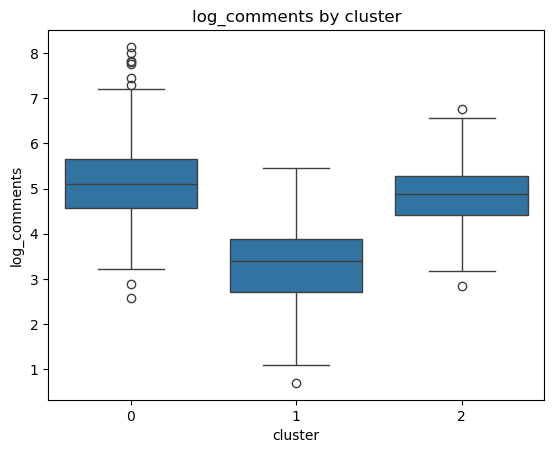

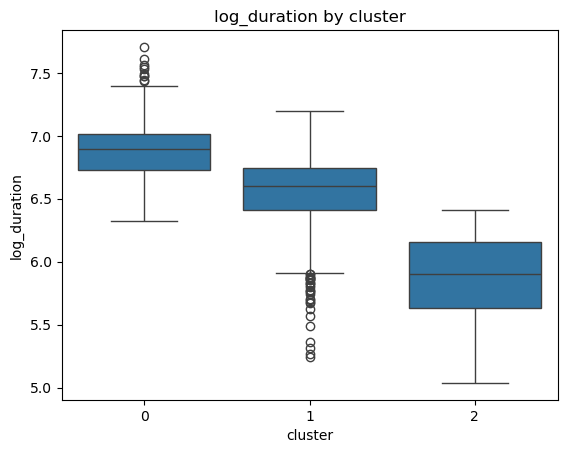

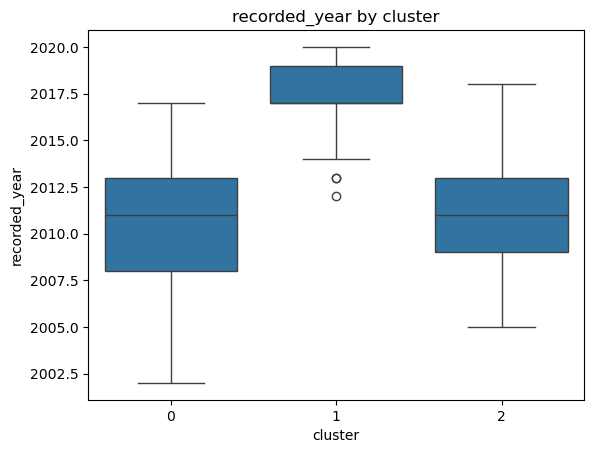

In [ ]:

#box plot visualization of results
for col in ["log_comments", "log_duration", "recorded_year"]:
    sns.boxplot(x="cluster", y=col, data=df)
    plt.title(f"{col} by cluster")
    plt.show()